In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
import utils

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

Init Plugin
Init Graph Optimizer
Init Kernel
2.5.0


### Load dataset

In [2]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)

(68528, 7)


### Preprocessing

In [3]:
# Normalize both features and labels
x_min = dataset.min()
x_max = dataset.max()

x_train_raw = (dataset - x_min) / (x_max - x_min)

In [4]:
window = 1000
stride = 20
telescope = 1
batch_size = 32
epochs = 100
patience = 10
factor = 0.5
min_lr = 1e-5
models_folder = 'baseline'
model_version = '32-64lstm_1000w_20s_AR'
path_to_model = os.path.join(os.path.join('.', models_folder), model_version)

In [5]:
x_train, y_train = utils.build_sequences(x_train_raw, 
                                         dataset.columns, 
                                         window, 
                                         stride, 
                                         telescope)
x_train.shape, y_train.shape

((3400, 1000, 7), (3400, 1, 7))

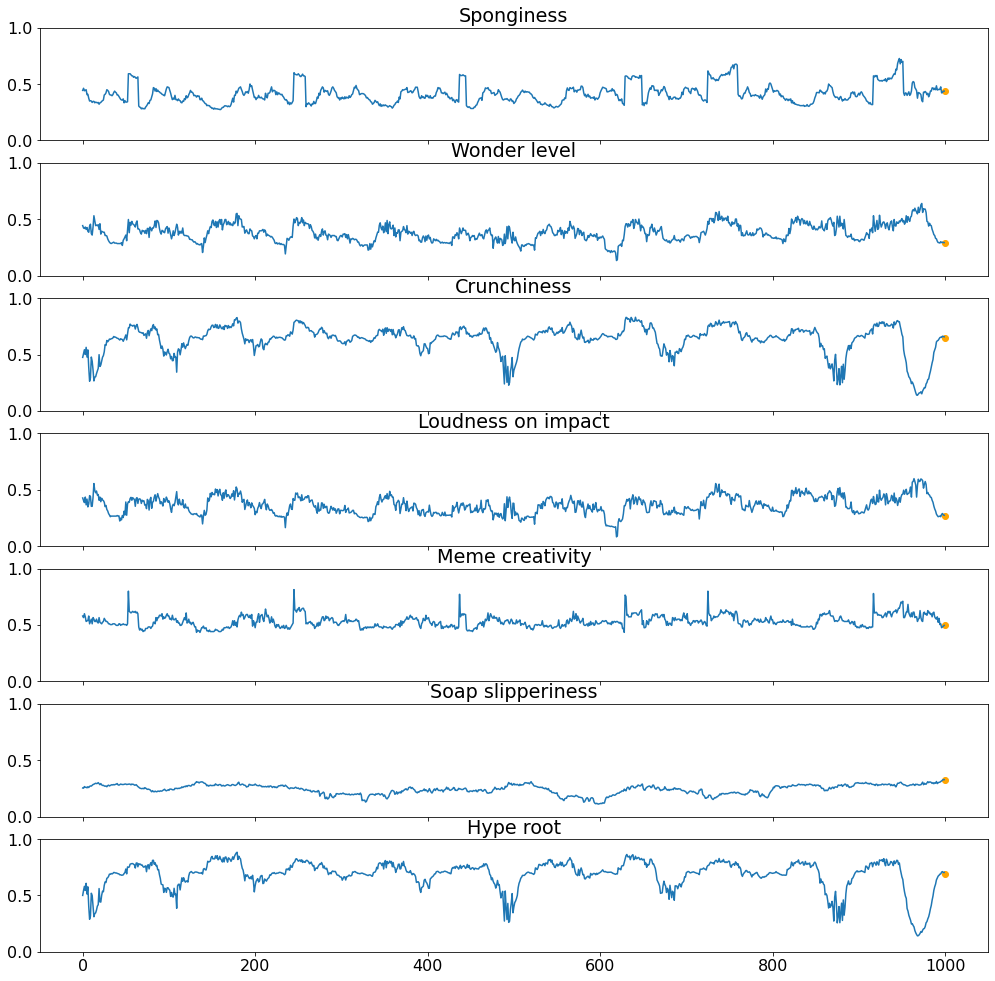

In [6]:
utils.inspect_multivariate(x_train, y_train, dataset.columns, telescope)

In [7]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(input_layer)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)

    # In order to predict the next values for more than one sensor,
    # we can use a Dense layer with a number given by telescope*num_sensors,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_sensors]
    dense = tfkl.Dense(output_shape[-1] * output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=utils.metrics())

    # Return the model
    return model

In [8]:
model = build_CONV_LSTM_model(x_train.shape[1:], y_train.shape[1:])
model.summary()

# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = utils.callbacks(which_monitor='val_loss', 
                                maxOrMin='min', 
                                patience=patience, 
                                factor=factor, 
                                min_lr=min_lr, 
                                model_version=model_version, 
                                models_folder=models_folder)
).history

Metal device set to: Apple M1 Pro


2021-12-19 16:54:17.890530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-19 16:54:17.890662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1000, 7)]         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 64)          10240     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 128)         66048     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
_________________________________________________________________
reshape (Reshape)            (None, 1, 7)              0         
Total params: 77,191
Trainable params: 77,191
Non-trainable params: 0
_________________________________________________________

2021-12-19 16:54:18.277975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-19 16:54:18.278143: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-19 16:54:19.426866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 16:54:19.619442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 16:54:19.628568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 16:54:27.161199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-19 16:54:27.170466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

KeyboardInterrupt: 

In [ ]:
model.save(path_to_model)

In [ ]:
utils.plot_and_save(history, model_version, models_folder)

In [ ]:
# to load old history from file
# old_history = np.load(os.path.join(path_to_model, 'history.npy'), allow_pickle='TRUE').item()

In [ ]:
def predict_with_AR(model, preprocessed_past_data, telescope):
    out = np.array([])
    x_tmp = preprocessed_past_data
    for reg in range(telescope):
        pred_tmp = model.predict(x_tmp)
        if(len(out)==0):
            out = pred_tmp
        else:
            out = np.concatenate((out,pred_tmp),axis=1)
        x_tmp = np.concatenate((x_tmp[:,1:,:],pred_tmp), axis=1)
    return out

x = dataset.to_numpy()
x_min = x.min(axis=0)
x_max = x.max(axis=0)

past_data = x[-1000:]
past_data = (past_data - x_min) / (x_max - x_min)
past_data = np.expand_dims(past_data, axis=0)

out = predict_with_AR(model, past_data, 864)

# Insert your postprocessing here
out = out * (x_max - x_min) + x_min
out = np.reshape(out, (864, 7))
utils.inspect_multivariate_prediction(x, out, dataset.columns , 864, models_folder, model_version)

In [ ]:
model_version, models_folder